---
title: "Download Skeletons"
aliases: 
    - em_py_04_skeleton_pathlength.html
    - ../programmatic_access/em_py_04_skeleton_pathlength.html
draft: false
format: 
    html:
        toc: true 
        code-fold: false
        code-links:
          - text: Download Quickstart Notebooks
            icon: file-code
            href: https://github.com/AllenInstitute/microns_tutorial/tree/main/tutorial_book/quickstart_notebooks
execute:
    eval: False
    warning: False
jupyter: python3
---

{{< include ../_annotation_tables/_version_tip.qmd >}}

## Connected morphological representations: skeletons

Often in thinking about neurons, you want to measure things along a linear dimension of a neuron.

However, the segmentation and meshes are a full complex 3d shape that makes this non-trivial. There are methods for reducing the shape of a segmented neuron down to a linear tree like structure usually referred to as a __skeleton__. We have precalculated skeletons for a large number of cells in the dataset, and make the skeleton generation available on our server, on demand. 

The meshes that one sees in Neuroglancer are available to download through the python client [cloud-volume](https://github.com/seung-lab/cloud-volume), and can be loaded for analysis and visualization in other tools.

{{< include _morphological_representations.qmd >}}



## What is a Precomputed skeleton?

These skeletons are stored in the cloud as a bytes-IO object, which can be viewed in __Neuroglancer__, or downloaded with __CAVEclient.skeleton__ module. These precomputed skeletons also contain annotations on the skeletons that have the synapses, which skeleton nodes are axon and which are dendrite, and which are likely the apical dendrite of excitatory neurons.


![pyChunkedGraph Skeleton](../img/skeleton-cartoon.png)

For more on how skeletons are generated from the mesh objects, and additional tools for generating, cacheing, and downloading meshes, [see the Skeleton Service documentation](https://caveconnectome.github.io/CAVEclient/tutorials/skeletonization/)

## CAVEclient to download skeletons
Retrieve a skeleton using `get_skeleton()`. The available output_formats (described below) are:

* `dict` containing vertices, edges, radius, compartment, and various metadata (default if unspecified)
* `swc` a Pandas Dataframe in the SWC format, with ordered vertices, edges, compartment labels, and radius.

Note: if the skeleton doesn't exist in the server cache, it may take 20-60 seconds to generate the skeleton before it is returned. This function will block during that time. Any subsequent retrieval of the same skeleton should go very quickly however.

::: {.callout-important}
## Initial Setup
Before using any programmatic access to the data, [you first need to set up your CAVEclient token](em_py_01_caveclient_setup.html).
:::

In [1]:
from caveclient import CAVEclient
import numpy as np
import pandas as pd

client = CAVEclient("minnie65_public")

# specify the materialization version, for consistency across time",
client.version = 1412

# Example: pyramidal cell in v1412
example_cell_id = 864691135572530981

In [2]:
sk_df = client.skeleton.get_skeleton(example_cell_id, output_format='swc')

sk_df.head()

,id,type,x,y,z,radius,parent
0,0,1,1365.120,763.456,812.60,3.643,-1
1,1,3,1368.200,755.760,811.24,0.300,0
2,2,3,1368.200,758.552,811.68,1.915,1
3,3,3,1368.200,758.560,812.12,1.915,2
4,4,3,1368.192,758.560,812.44,2.815,3


Skeletons are "tree-like", where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices. Because of this, for a skeleton there are well-defined directions "away from root" and "towards root" and few types of vertices have special names:

You can see these vertices and edges represented in the alternative `dict` skeleton output.

In [3]:
sk_dict = client.skeleton.get_skeleton(example_cell_id, output_format='dict')

sk_dict.keys()

dict_keys(['meta', 'edges', 'mesh_to_skel_map', 'root', 'vertices', 'compartment', 'radius'])

Alternately, you can query a set of root_ids, for example all of the **proofread cells** in the dataset, and bulk download the skeletons

In [4]:
prf_root_ids = client.materialize.tables.proofreading_status_and_strategy(
    status_axon='t').query()['pt_root_id']
prf_root_ids.head(3)

0    864691135308929350
1    864691135163673901
2    864691136812081779
Name: pt_root_id, dtype: int64

In [5]:
all_sk_dict = client.skeleton.get_bulk_skeletons(
    prf_root_ids.head(3), 
    generate_missing_skeletons=True,
    output_format='dict',
    skeleton_version=4)

all_sk_dict.keys()

dict_keys(['864691135308929350', '864691135163673901', '864691136812081779'])

In [6]:
all_sk_dict['864691135308929350'].keys()

dict_keys(['meta', 'edges', 'mesh_to_skel_map', 'root', 'vertices', 'compartment', 'radius', 'lvl2_ids'])

### convert dictionary to meshwork skeleton
We use the python package __Meshparty__ to convert between mesh representations of neurons, and skeleton representations. 

See [Download Meshes | MeshParty](06-cloudvolume-download-meshes.html) for more details.

Skeletons are "tree-like", where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices. Because of this, for a skeleton there are well-defined directions "away from root" and "towards root" and few types of vertices have special names:

Converting the pregenerated skeleton `sk_dict` to a meshwork object `sk` converts the skeleton to a graph object, for convenient representation and analysis.

In [7]:
from meshparty.skeleton import Skeleton

sk = Skeleton.from_dict(sk_dict)

## Plot with skeleton_plot


Our convenience package __skeleton_plot__ renders the skeleton in aligned, 2D views.

```python
pip install skeleton_plot
```

Our convenience package __skeleton_plot__ renders the skeleton in aligned, 2D views, with the compartments labeled in different colors. Here, _dendrite_ is red, _axon_ is blue, and _soma_ (the root of the connected graph) is olive

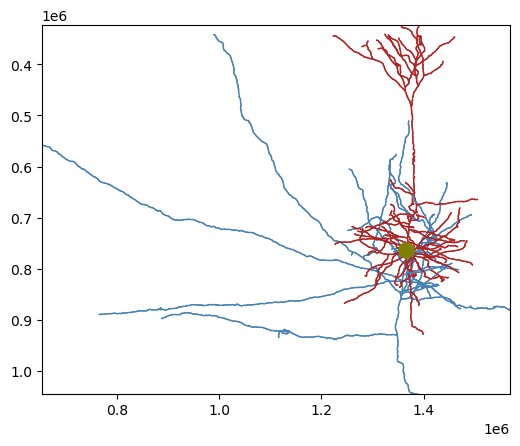

In [8]:
from skeleton_plot.plot_tools import plot_skel

plot_skel(sk=sk,
          invert_y=True,
          pull_compartment_colors=True,
          plot_soma=True,
         )

## Download or generate skeletons with `pcg_skel`

`pcg_skel` is a package used to rapidly build neuronal skeletons from electron microscopy data in the CAVE ecosystem. It integrates structural data, connectivity data, and local features stored across many aspects of a CAVE system, and creates objects as [Meshparty](https://github.com/CAVEconnectome/MeshParty) meshes, skeletons, and MeshWork files for subsequent analysis. 

By harnessing the way the structural data is stored, you can build skeletons for even very large neurons quickly and with little memory use.

To install pcg_skel, use pip. 

```python
pip install pcg_skel
```

By loading a skeleton as a meshwork skeleton, you can easily 'rehydrate' the mesh features of the neuron (annotations such as **synapses** and **compartment labels**) and MeshParty functions (such as *masking* and *pathlength*)

In [9]:
from pcg_skel import get_meshwork_from_client

sk_mesh = get_meshwork_from_client(example_cell_id,
                                   client=client,
                                   synapses=True,
                                   restore_graph=True,
                                   restore_properties=True,
                                   skeleton_version=4,
)
sk_mesh

Skeletons are "tree-like", where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices. Because of this, for a skeleton there are well-defined directions "away from root" and "towards root" and few types of vertices have special names:

* `Branch point`: vertices with two or more children, where a neuronal process splits.
* `End point`: vertices with no childen, where a neuronal process ends.
* `Root point`: The one vertex with no parent node. By convention, we typically set the root vertex at the cell body, so these are equivalent to "away from soma" and "towards soma".
* `Segment`: A collection of vertices along an unbranched region, between one branch point and the next end point or branch point downstream.

MeshWork skeletons represent the neuron as a graph, with tools and properties to utilize the skeleton `csgraph`.

**Properties**

* `branch_points`: a list of skeleton vertices which are branches
* `root`: the skeleton vertice which is the soma
* `distance_to_root`: an array the length of vertices which tells you how far away from the root each vertex is
* `root_position`: the position of the root node in nanometers
* `end_points`: the tips of the neuron
* `cover_paths`: a list of arrays containing vertex indices that describe individual paths that in total cover the neuron without repeating a vertex. Each path starts at an end point and continues toward root, stopping once it gets to a vertex already listed in a previously defined path. Paths are ordered to start with the end points farthest from root first. Each skeleton vertex appears in exactly one cover path.
* `csgraph`: a scipy.sparse.csr.csr_matrix containing a graph representation of the skeleton. Useful to do more advanced graph operations and algorithms. https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html
* `kdtree`: a scipy.spatial.ckdtree.cKDTree containing the vertices of skeleton as a kdtree. Useful for quickly finding points that are nearby. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

**Methods**

* `path_length(paths=None)`: the path length of the whole neuron if no arguments, or pass a list of paths to get the path length of that. A path is just a list of vertices which are connected by edges.
* `path_to_root(vertex_index)`: returns the path to the root from the passed vertex
* `path_between(source_index, target_index)`: the shortest path between the source vertex index and the target vertex index
* `child_nodes(vertex_indices)`: a list of arrays listing the children of the vertex indices passed in
* `parent_nodes(vertex_indices)`: an array listing the parent of the vertex indices passed in

You access each of these properties and methods with `sk.skeleton.*` Use the ? to read more details about each one

### Annotation properties

`sk.anno` has set of annotation tables containing some additional information for analysis.
Each annotation table has both a Pandas DataFrame object storing data and additional information that allow the rows of the DataFrame to be mapped to mesh and skeleton vertices.
For the neurons that have been pre-computed, there is a consisent set of annotation tables:

* `post_syn`: Postsynaptic sites (inputs) for the cell
* `pre_syn`: Presynaptic sites (outputs) for the cell
* `is_axon`: List of vertices that have been labeled as part of the axon
* `lvl2_ids`: Gives the PCG level 2 id for each mesh vertex, largely for book-keeping reasons.
* `segment_properties`: For each vertex, information about the approximate radius, surface area, volume, and length of the segment it is on.
* `vol_prop`: For every vertex, information about the volume and surface area of the level 2 id it is associated with.

To access one of the DataFrames, use the name of the table as an attribute of the `anno` object and then get the `.df` property. For example, to get the postsynaptic sites, we can do:

In [10]:
sk_mesh.anno.post_syn.df.head(3)

,id,size,pre_pt_supervoxel_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,post_pt_level2_id,post_pt_mesh_ind,post_pt_mesh_ind_filt
0,456611088,5140,113239596703504810,113239596703516355,864691135572530981,"[1410648.0, 729000.0, 850240.0]","[1410800.0, 728960.0, 850520.0]","[1410672.0, 728960.0, 850280.0]",185297190741082374,11880,11880
1,460786295,1904,114084296310348680,114084365029814954,864691135572530981,"[1434984.0, 737808.0, 794360.0]","[1435488.0, 738120.0, 794120.0]","[1435224.0, 737856.0, 794400.0]",186141959067271764,13325,13325
2,415745273,14532,110214290325399938,110214290325398722,864691135572530981,"[1322336.0, 744768.0, 807360.0]","[1322032.0, 744560.0, 807440.0]","[1322120.0, 744656.0, 807360.0]",182271884363039168,3695,3695


However, in addition to these rows, you can also easily get the mesh vertex index or skeleton vertex index that a row corresponds to with `nrn.anno.post_syn.mesh_index` or `nrn.anno.post_syn.skel_index` respectively.
This seems small, but it allows you to integrate skeleton-like measurements with annotations trivially.

For example, to get the distance from the cell body for each postsynaptic site, we can do:

In [11]:
sk_mesh.distance_to_root(sk_mesh.anno.post_syn.mesh_index)

array([104938.90991211,  90399.17230225,  52673.86270142, ...,
        70199.43048096, 212153.28248978,  91076.815979  ])

::: {.callout-note}
Note that the `sk.distance_to_root`, like all basic meshwork object functions, expects a mesh vertex index rather than a skeleton vertex index.
:::

A common pattern is to copy a synapse dataframe and then add columns to it.
For example, to add the distance to root to the postsynaptic sites, we can do:

In [12]:
syn_df = sk_mesh.anno.pre_syn.df.copy()
syn_df['dist_to_root'] = sk_mesh.distance_to_root(sk_mesh.anno.pre_syn.mesh_index)
syn_df.head(3)[['id','size','dist_to_root']]

,id,size,dist_to_root
0,395248437,9532,550625.977657
1,440616430,4432,59338.621429
2,439592768,576,426225.854660


This gives us the path-distance of every synapse from the `root` in nanometers (nm).

### Calculate `path_length()` of axon and dendrite

Given the skeleton graph, it is trivial to estimate the pathlength (sum of all branch lengths) for a neuron:

In [13]:
sk_mesh.path_length() / 1e6 # to convert from nm to mm

np.float32(14.846251)

However, the axon and dendrite compartments differ dramatically in their geometric and physiological properties. You generally will want to treat these seperately.

Fortunately the meshwork skeleton includes annotations as to whether the compartment is likely axon or not:

```
sk_mesh.anno.is_axon

````

and you can *mask* the neuron skeleton by the type of comparment simply by using these annotations as an index:

In [14]:
# Apply a mask to the mesh using the axon labels
sk_mesh.apply_mask(sk_mesh.anno.is_axon.mesh_mask)

print (f'Axon path length is {sk_mesh.path_length() / 1e6} mm')

# Reset the mask
sk_mesh.reset_mask()

print (f'Total path length is {sk_mesh.path_length() / 1e6} mm')

Axon path length is 7.599738121032715 mm
Total path length is 14.846250534057617 mm
